## KNN FROM SCRATCH USING TFIDF WORD EMBEDDING & TFIDF FEATURE SELECTION

### IMPORTING REQUIRED MODULES

In [1]:
import re
from nltk import word_tokenize
import glob  
from nltk.corpus import stopwords
import time
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
import os
import sys 
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import math
import json
import numpy as np
import pandas as  pd
from prettytable import PrettyTable
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from statistics import mode
from sklearn.metrics import confusion_matrix
import itertools
import copy
from itertools import islice
from IPython.display import display

### DATA-PREPROCESSING FUNCTION

In [2]:
def preprocess(data):
    stopword=""
    cleantext = " "
    stopword = set(stopwords.words('english'))
    for i in word_tokenize(data):
        i=i.lower()
        if i not in stopword and len(i)>2 and not(any(l.isdigit() for l in i)):
            pattern1 = '[!.?$\[\]/\}#=<>"\*:,|_~;()^\']'
            pattern2 = '[\n\n]+'
            pattern3 = '[\ \ ]+'
            wout_sc = re.sub(pattern1,'',i) #removing special characters
            wout_el = re.sub(pattern2,'\n',wout_sc) # removing empty lines (which are greater than 2)
            wout_mspaces = re.sub(pattern3,' ',wout_el) # removing multiple spaces
            cleaned_text = wout_mspaces.strip()
            cleaned_text=lemmatizer.lemmatize(cleaned_text)
            cleantext = cleantext+cleaned_text+" "
    return cleantext.strip()

### READING THE NAMES OF ALL THE FILES ATTACHED WITH CORRESPONDING CLASS NAME

In [3]:
def read_names(path):
    i=0
    df = pd.DataFrame(columns=['Doc_Name'])
    folders = glob.glob(path)
    for f in tqdm(folders,leave=True,position=0):
        head,tail = os.path.split(f)
        if(tail=="comp.graphics"or tail=="sci.med"or tail=="talk.politics.misc"or tail=="rec.sport.hockey"or tail=="sci.space"):
            for file in glob.glob(f+"\*"):
                head1,tail1 = os.path.split(file)
                df.loc[i] = tail+"_"+tail1
                i=i+1
    return df

### PERFORMING TRAIN-TEST SPLIT FOR FILE NAMES 

In [4]:
def split(ratio,data_frame):
    data_frame_temp = data_frame.copy()
    train_files,test_files = train_test_split(data_frame_temp,train_size=ratio,random_state=0)
    return train_files,test_files

### READING THE DATA & BUILDING TFs and DFs FOR TRAINING SET
### CORPUS CONSIDERED :: "20 news groups" 
### FOLDERS CONSIDERED: 
### 1. comp.graphics 
### 2. sci.med 
### 3.talk.politics.misc 
### 4.rec.sport.hockey 
### 5.sci.space

In [5]:
def readfiles(path,ratio,test_files):
    folders = glob.glob(path)
    preproc_data_dict={} ## key : file-name, value: pre-processed data
    tfs_class_wise={}
    df_dict={}
    train_files_class_wise={}
    test_preproc_dict={}
    train_files_doc_wise={}
    tfs_doc_wise={}
    df_dict_doc_wise={}
    for f in tqdm(folders,leave=True,position=0):
        head,tail = os.path.split(f)
        if(tail=="comp.graphics"or tail=="sci.med"or tail=="talk.politics.misc"or tail=="rec.sport.hockey"or tail=="sci.space"):
            for file in glob.glob(f+"\*"):
                flag=0
                head1,tail1 = os.path.split(file)
                with open(file) as newlinetest:   ## identifying the first new line in the data.. to remove meta-data
                    indi = newlinetest.readlines()
                for newline in range(len(indi)):
                    if(indi[newline]!="\n"):
                        continue
                    break
                filedata=[]
                try:
                    with open(file,"r") as data:  ## READING THE DATA ignoring the meta-data
                        filedata.append(data.readlines()[newline+1:])
                        for l in range(len(filedata)):
                            inter_data = ' '.join(filedata[l])
                    preproc_data = preprocess(inter_data)
                    if(tail+"_"+tail1 not in list(test_files['Doc_Name'])): ## reading only the training data
                        train_files_doc_wise[tail+"_"+tail1] = preproc_data
                        if tail not in train_files_class_wise:
                            train_files_class_wise[tail]=1
                        else:
                            train_files_class_wise[tail]+=1
                        if tail not in preproc_data_dict: ## merging the data of all documents belonging to a single class..
                            preproc_data_dict[tail] = preproc_data
                        else:
                            preproc_data_dict[tail] = preproc_data_dict[tail]+" "+preproc_data
                    else:
                        test_preproc_dict[tail+"_"+tail1] = preproc_data
                    
                except e:
                    print("EXCEPTION OCCURED..")
                
                    
    print("TOTAL TRAINING FILES READ::",len(train_files_doc_wise.keys()))
    
    print("\n====> GENERATING TFs DOC WISE...\n")
    for d in tqdm(train_files_doc_wise,leave=True,position=0): ## computing term-frequencies doc-wise....
        tf_dict={}
        for w in train_files_doc_wise[d].split():
            if w not in tf_dict:
                tf_dict[w]=1
            else:
                tf_dict[w]+=1
        tfs_doc_wise[d] = tf_dict
    
    print("\n====> GENERATING IDFs DOC WISE...\n")
    
    #data=" "  
    #for d in train_files_doc_wise: ## computing inverse document frequencies doc-wise...
    #    data = data+" "+train_files_doc_wise[d] ## computing inverse document frequencies...
    #unique_words = list(set(data.split()))
    #for w in tqdm(unique_words,leave=True,position=0):
    #    df_dict_doc_wise[w]=0
    #    for key in train_files_doc_wise:
    #        if w in train_files_doc_wise[key].split():
    #            df_dict_doc_wise[w]+=1
    #    df_dict_doc_wise[w] = math.log10(len(train_files_doc_wise.keys())/df_dict_doc_wise[w])
    
    if(ratio==0.50):
        pickle_in = open("df_docwise_knn_tfidf_5050","rb")
        df_dict_doc_wise = pickle.load(pickle_in)
        print("DOC WISE IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!")
    if(ratio==0.70):
        pickle_in = open("df_docwise_knn_tfidf_7030","rb")
        df_dict_doc_wise = pickle.load(pickle_in)
        print("DOC WISE IDF VALUES CORRESPONDING TO 70:30 SPLIT LOADED...!!!")
    if(ratio==0.80):
        pickle_in = open("df_docwise_knn_tfidf_8020","rb")
        df_dict_doc_wise = pickle.load(pickle_in)
        print("DOC WISE IDF VALUES CORRESPONDING TO 80:20 SPLIT LOADED...!!!")
    
    tfidfs_doc_wise = copy.deepcopy(tfs_doc_wise)
    
    print("\n====> GENERATING TF-IDFS DOC WISE...\n")
    for i in tqdm(tfidfs_doc_wise,leave=True,position=0):
        for j in tfidfs_doc_wise[i]:
            tfidfs_doc_wise[i][j] = (1+math.log10(tfidfs_doc_wise[i][j]))*df_dict_doc_wise[j]
    
    print("\n====> GENERATING/LOADING IDFs CLASS WISE...\n")
    if(ratio==0.50):
        pickle_in = open("df_nb_tfidf_5050","rb")
        df_dict = pickle.load(pickle_in)
        print("CLASS WISE IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!")
    if(ratio==0.70):
        pickle_in = open("df_nb_tfidf_7030","rb")
        df_dict = pickle.load(pickle_in)
        print("CLASS WISE IDF VALUES CORRESPONDING TO 70:30 SPLIT LOADED...!!!")
    if(ratio==0.80):
        pickle_in = open("df_nb_tfidf_8020","rb")
        df_dict = pickle.load(pickle_in)
        print("CLASS WISE IDF VALUES CORRESPONDING TO 80:20 SPLIT LOADED...!!!")
        
    #data=" "
    #for d in preproc_data_dict:
    #    data = data+" "+preproc_data_dict[d] ## computing inverse document frequencies class-wise...
    #unique_words = list(set(data.split()))
    #for w in tqdm(unique_words,leave=True,position=0):
    #    df_dict[w]=0
    #    for key in preproc_data_dict:
    #        if w in preproc_data_dict[key].split():
    #            df_dict[w]+=1
    #    df_dict[w] = math.log10(len(preproc_data_dict.keys())/df_dict[w]) ##preproc_data_dict.keys() ==> total number of classes
    print("LENGTH OF VOCABULARY::",len(df_dict))
    
    print("\n====> GENERATING TFs CLASS WISE...\n")
    for d in tqdm(preproc_data_dict,leave=True,position=0): ## computing term-frequencies....
        tf_dict={}
        for w in preproc_data_dict[d].split():
            if w not in tf_dict:
                tf_dict[w]=1
            else:
                tf_dict[w]+=1
        tfs_class_wise[d] = tf_dict
    tfidfs_class_wise = copy.deepcopy(tfs_class_wise)
    
    print("\n====> GENERATING TF-IDFS...\n")
    for i in tqdm(tfidfs_class_wise,leave=True,position=0):
        for j in tfidfs_class_wise[i]:
            tfidfs_class_wise[i][j] = (1+math.log10(tfidfs_class_wise[i][j]))*df_dict[j]
    return tfidfs_class_wise,tfs_class_wise,test_preproc_dict,tfidfs_doc_wise,df_dict_doc_wise,train_files_class_wise

### PICKLING DOC WISE IDF VALUES

In [6]:
#pickle_out = open("df_docwise_knn_tfidf_5050","wb")
#pickle.dump(df_dict_doc_wise, pickle_out)
print("PICKLED DOC WISE IDFs corresponding to 50-50 split")

PICKLED DOC WISE IDFs corresponding to 50-50 split


In [7]:
#pickle_out = open("df_docwise_knn_tfidf_7030","wb")
#pickle.dump(df_dict_doc_wise, pickle_out)
print("PICKLED DOC WISE IDFs corresponding to 70-30 split")

PICKLED DOC WISE IDFs corresponding to 70-30 split


In [8]:
#pickle_out = open("df_docwise_knn_tfidf_8020","wb")
#pickle.dump(df_dict_doc_wise, pickle_out)
print("PICKLED DOC WISE IDFs corresponding to 80-20 split")

PICKLED DOC WISE IDFs corresponding to 80-20 split


### GENERATING VECTORS FOR TRAINING AND TEST DOCUMENTS

In [9]:
def gen_vectors(tfidfs_class_wise,tfidfs_doc_wise,test_preproc_dict,df_dict_doc_wise):
    top_features=set()
    test_temp={}
    test_vectors_tfidfs={}
    train_vectors={}
    test_vectors={}
    for i in tfidfs_class_wise: ## combining top features of all classes...
        top_features = top_features | set(list(tfidfs_class_wise[i].keys()))
        
    print("\n====> GENERATING TRAINING VECTORS & PEFORMING FEATURE SELECTION...")
    for i in tqdm(tfidfs_doc_wise,leave=True,position=0): ## generating training vectors...
        vector=[]
        for j in top_features:
            if j in tfidfs_doc_wise[i]:
                vector.append(tfidfs_doc_wise[i][j])
            else:
                vector.append(0)
        train_vectors[i]=vector
    
    print("\n====> GENERATING TEST VECTORS AND PERFORMING FEATURE SELECTION...")
    for i in tqdm(test_preproc_dict,leave=True,position=0): ## generating test vectors
        test_vectors_temp={}
        for j in test_preproc_dict[i].split():
            if j in top_features:
                if j not in test_vectors_temp:
                    test_vectors_temp[j]=1
                else:
                    test_vectors_temp[j]+=1
        test_vectors_tfidfs[i]=test_vectors_temp
    #print("test_vectors_tfidfs::",test_vectors_tfidfs)
    for i in test_vectors_tfidfs: ## generating tfidfs for test vector...
        for j in test_vectors_tfidfs[i]:
            test_vectors_tfidfs[i][j] = (1+math.log10(test_vectors_tfidfs[i][j]))*df_dict_doc_wise[j]
    
    for i in test_preproc_dict: ## generating training vectors...
        vector=[]
        for j in top_features:
            try:
                vector.append(test_vectors_tfidfs[i][j])
            except:
                vector.append(0)
        test_vectors[i]=vector
    return train_vectors,test_vectors

## CODE EXECUTION STARTS HERE...

In [11]:
path = "C:\\Users\\Sai Kumar\\Desktop\\SEM-2\\IR\\20NEWS\\20_newsgroups\\*"
train_size=[]
features=[]
perf=[]
dec = "y"
while(dec == "y" or dec =="Y"):
    print("\n====> READING NAMES OF THE FILES...\n")
    files_df = read_names(path)
    ratio = float(input("ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::"))
    train_files,test_files = split(ratio,files_df)
    print("COUNT OF TRAINING FILES CONSIDERED::",len(train_files))
    print("COUNT OF TEST FILES CONSIDERED::",len(test_files))
    print("\n====> READING DOCUMENTS...\n")
    tfidfs_class_wise,tfs_class_wise,test_preproc_dict,tfidfs_doc_wise,df_dict_doc_wise,train_files_class_wise=readfiles(path,ratio,test_files)
    train_files_class_wise = dict(sorted(train_files_class_wise.items(),key=operator.itemgetter(1),reverse=True))
    feat_selection = int(input("ENTER THE COUNT OF FEATURES TO BE SELECTED FROM EACH CLASS::"))
    for i in tfidfs_class_wise:
        tfidfs_class_wise[i] = dict(sorted(tfidfs_class_wise[i].items(),key=operator.itemgetter(1),reverse=True))
        tfidfs_class_wise[i] = dict(itertools.islice(tfidfs_class_wise[i].items(),feat_selection))
    train_vectors,test_vectors = gen_vectors(tfidfs_class_wise,tfidfs_doc_wise,test_preproc_dict,df_dict_doc_wise)
    print("\n====> GENERATING PREDICTIONS...\n")
    ground_truth=[]
    predictions_1=[]
    predictions_3=[]
    predictions_5=[]
    classes=list(train_files_class_wise.keys())
    for i in tqdm(test_vectors,leave=True,position=0):
        ground_truth.append(i.split("_")[0])
        results={}
        cou = 0
        for j in train_vectors:
            A_dot_B = np.array(train_vectors[j]) @ np.array(test_vectors[i]) 
            mod_A = np.sqrt(np.array(train_vectors[j]) @ np.array(train_vectors[j]))
            mod_B = np.sqrt(np.array(test_vectors[i]) @ np.array(test_vectors[i]))
            value = A_dot_B/(mod_A*mod_B)
            if math.isnan(value):
                results[j] = -99999999  #if any of the vector magnitude is 0,cosine-sim becomes 0/0 which is undefined so assigning 
                                        #some large negative value
            else:
                results[j] = value

        results = dict(sorted(results.items(),key=operator.itemgetter(1),reverse=True))
        predictions_1.append(list(results.keys())[0].split("_")[0])
        pred=[]
        for r in list(results.keys())[0:3]:
            pred.append(r.split("_")[0])
        try:
            predictions_3.append(mode(pred))
        except:
            predictions_3.append(list(train_files_class_wise.keys())[0])
        pred=[]
        for r in list(results.keys())[0:5]:
            pred.append(r.split("_")[0])
        try:
            predictions_5.append(mode(pred))
        except:
            predictions_5.append(list(train_files_class_wise.keys())[0])
    acc=[0,0,0]
    for i in range(len(ground_truth)):
        if(ground_truth[i]==predictions_1[i]):
            acc[0]+=1
        if(ground_truth[i]==predictions_3[i]):
            acc[1]+=1
        if(ground_truth[i]==predictions_5[i]):
            acc[2]+=1
    print("ACCURACY WITH K=1::",acc[0]*100/len(predictions_1))
    print("ACCURACY WITH K=3::",acc[1]*100/len(predictions_1))
    print("ACCURACY WITH K=5::",acc[2]*100/len(predictions_1))
    print("CONFUSION MATRIX ON TEST DATA WITH K=1:: ")
    #ref:https://stackoverflow.com/questions/50325786/sci-kit-learn-how-to-print-labels-for-confusion-matrix
    conf_df = pd.DataFrame(confusion_matrix(ground_truth,predictions_1),columns=classes,index=classes)
    conf_df.index.name = 'True labels'
    display(conf_df)
    print("CONFUSION MATRIX ON TEST DATA WITH K=3:: ")
    conf_df = pd.DataFrame(confusion_matrix(ground_truth,predictions_3),columns=classes,index=classes)
    conf_df.index.name = 'True labels'
    display(conf_df)
    print("CONFUSION MATRIX ON TEST DATA WITH K=5:: ")
    conf_df = pd.DataFrame(confusion_matrix(ground_truth,predictions_5),columns=classes,index=classes)
    conf_df.index.name = 'True labels'
    display(conf_df)
    dec = input("DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::")


====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.50
COUNT OF TRAINING FILES CONSIDERED:: 2500
COUNT OF TEST FILES CONSIDERED:: 2500

====> READING DOCUMENTS...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.12s/it]


TOTAL TRAINING FILES READ:: 2500

====> GENERATING TFs DOC WISE...



100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 9750.11it/s]



====> GENERATING IDFs DOC WISE...

DOC WISE IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!

====> GENERATING TF-IDFS DOC WISE...



100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 8931.69it/s]



====> GENERATING/LOADING IDFs CLASS WISE...

CLASS WISE IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!
LENGTH OF VOCABULARY:: 34414

====> GENERATING TFs CLASS WISE...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.14it/s]



====> GENERATING TF-IDFS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.66it/s]


ENTER THE COUNT OF FEATURES TO BE SELECTED FROM EACH CLASS::1000

====> GENERATING TRAINING VECTORS & PEFORMING FEATURE SELECTION...


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1445.35it/s]



====> GENERATING TEST VECTORS AND PERFORMING FEATURE SELECTION...


100%|███████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 21981.25it/s]



====> GENERATING PREDICTIONS...



100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [5:16:06<00:00,  5.94s/it]


ACCURACY WITH K=1:: 91.04
ACCURACY WITH K=3:: 91.4
ACCURACY WITH K=5:: 91.24
CONFUSION MATRIX ON TEST DATA WITH K=1:: 


,sci.space,sci.med,rec.sport.hockey,talk.politics.misc,comp.graphics
True labels,,,,,
sci.space,478,7,6,14,6
sci.med,14,477,2,0,7
rec.sport.hockey,41,0,431,15,8
talk.politics.misc,48,2,6,427,4
comp.graphics,30,4,7,3,463


CONFUSION MATRIX ON TEST DATA WITH K=3:: 


,sci.space,sci.med,rec.sport.hockey,talk.politics.misc,comp.graphics
True labels,,,,,
sci.space,478,7,4,14,8
sci.med,17,477,1,2,3
rec.sport.hockey,42,1,434,13,5
talk.politics.misc,40,2,4,436,5
comp.graphics,30,8,4,5,460


CONFUSION MATRIX ON TEST DATA WITH K=5:: 


,sci.space,sci.med,rec.sport.hockey,talk.politics.misc,comp.graphics
True labels,,,,,
sci.space,487,7,5,8,4
sci.med,15,484,0,0,1
rec.sport.hockey,59,2,418,10,6
talk.politics.misc,47,2,2,432,4
comp.graphics,34,8,1,4,460


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::n


### RESULTS

In [22]:
res = PrettyTable()
res.field_names = ["% OF TRAINING DATA CONSIDERED","K (in K-NN)","COUNT OF FEATURES(TF-IDF BASED)SELECTED/CLASS","TOTAL FEATURES","ACCURACY"]
res.add_row(["50 %","1","1000","5000","91.04 %"])
res.add_row(["50 %","3","1000","5000","91.4 %"])
res.add_row(["50 %","5","1000","5000","91.24 %"])
res.add_row(["70 %","1","1000","5000","91.93 %"])
res.add_row(["70 %","3","1000","5000","92.2 %"])
res.add_row(["70 %","5","1000","5000","92.0 %"])
res.add_row(["80 %","1","1000","5000","91.6 %"])
res.add_row(["80 %","3","1000","5000","91.8 %"])
res.add_row(["80 %","5","1000","5000","91.8 %"])
print(res)

+-------------------------------+-------------+-----------------------------------------------+----------------+----------+
| % OF TRAINING DATA CONSIDERED | K (in K-NN) | COUNT OF FEATURES(TF-IDF BASED)SELECTED/CLASS | TOTAL FEATURES | ACCURACY |
+-------------------------------+-------------+-----------------------------------------------+----------------+----------+
|              50 %             |      1      |                      1000                     |      5000      | 91.04 %  |
|              50 %             |      3      |                      1000                     |      5000      |  91.4 %  |
|              50 %             |      5      |                      1000                     |      5000      | 91.24 %  |
|              70 %             |      1      |                      1000                     |      5000      | 91.93 %  |
|              70 %             |      3      |                      1000                     |      5000      |  92.2 %  |
|       

### PLOTS

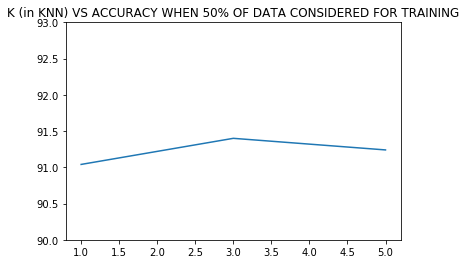

In [18]:
## K VS ACCURACY FOR 50:50
k=[1,3,5]
acc = [91.04,91.4,91.24]
plt.plot(k,acc)
plt.ylim(90,93)
plt.title("K (in KNN) VS ACCURACY WHEN 50% OF DATA CONSIDERED FOR TRAINING")
plt.show()

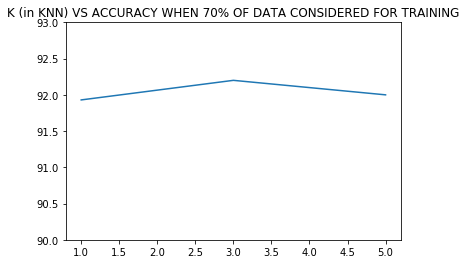

In [19]:
## K VS ACCURACY 70:30
k=[1,3,5]
acc = [91.93,92.2,92.0]
plt.plot(k,acc)
plt.ylim(90,93)
plt.title("K (in KNN) VS ACCURACY WHEN 70% OF DATA CONSIDERED FOR TRAINING")
plt.show()

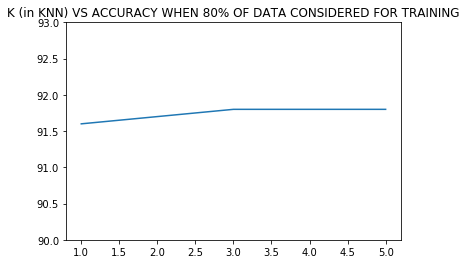

In [20]:
## K VS ACCURACY 80:20
k=[1,3,5]
acc = [91.6,91.8,91.8]
plt.plot(k,acc)
plt.ylim(90,93)
plt.title("K (in KNN) VS ACCURACY WHEN 80% OF DATA CONSIDERED FOR TRAINING")
plt.show()